# Setup, imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/honours
%ls

/content/drive/.shortcut-targets-by-id/19ffbnjWUM9FX-8Hcysq3IAN9wHHnO781/honours
all/                   hyperparameter_tuning.py  nonsaturated/      __pycache__/  sheets/
dried/                 model_creation.py         plot_functions.py  run_5fold.py
feature_extraction.py  model_plot.png            prep_functions.py  saturated/


In [ ]:
from prep_functions import create_images_list, extract_gh_values,extract_lp_values, circle_cut_out, scale_fit_transform
from plot_functions import plot_metrics,lin_regression,plot_predictions,plot_all_validation
from feature_extraction import get_distribution,get_image_contours,get_glcmprops,get_shape_features,get_lbp
from run_5fold import run_5fold,model_dict

In [ ]:
import pandas as pd
import numpy as np

# Data preparation

In [ ]:
#loading two datasets into respective dataframes
gh_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/GrievesHouse.csv')
lp_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/LowerPilmore.csv')

gh_df.head()

,Sample,Stable aggregates (%)
0,1,65.88
1,2,23.90
2,2,31.86
3,3,89.14
4,4,68.71


In [ ]:
# creating lists of images(scaled down) and respective label
gh_path = "/content/drive/MyDrive/honours/all/GrievesHouse/*.*"
lp_path = "/content/drive/MyDrive/honours/all/LowerPilmore/*.*"

gh_images,gh_labels = create_images_list(gh_path,(1024,1024),True)
lp_images,lp_labels = create_images_list(lp_path,(1024,1024),True)


In [ ]:
# CSV file naming differs from file naming - cleaning up:
gh_values = extract_gh_values(gh_labels,gh_df)
lp_values = extract_lp_values(lp_labels,lp_df)

all_values = gh_values + lp_values
all_values = np.array(all_values).reshape(-1, 1)

In [ ]:
from google.colab.patches import cv2_imshow

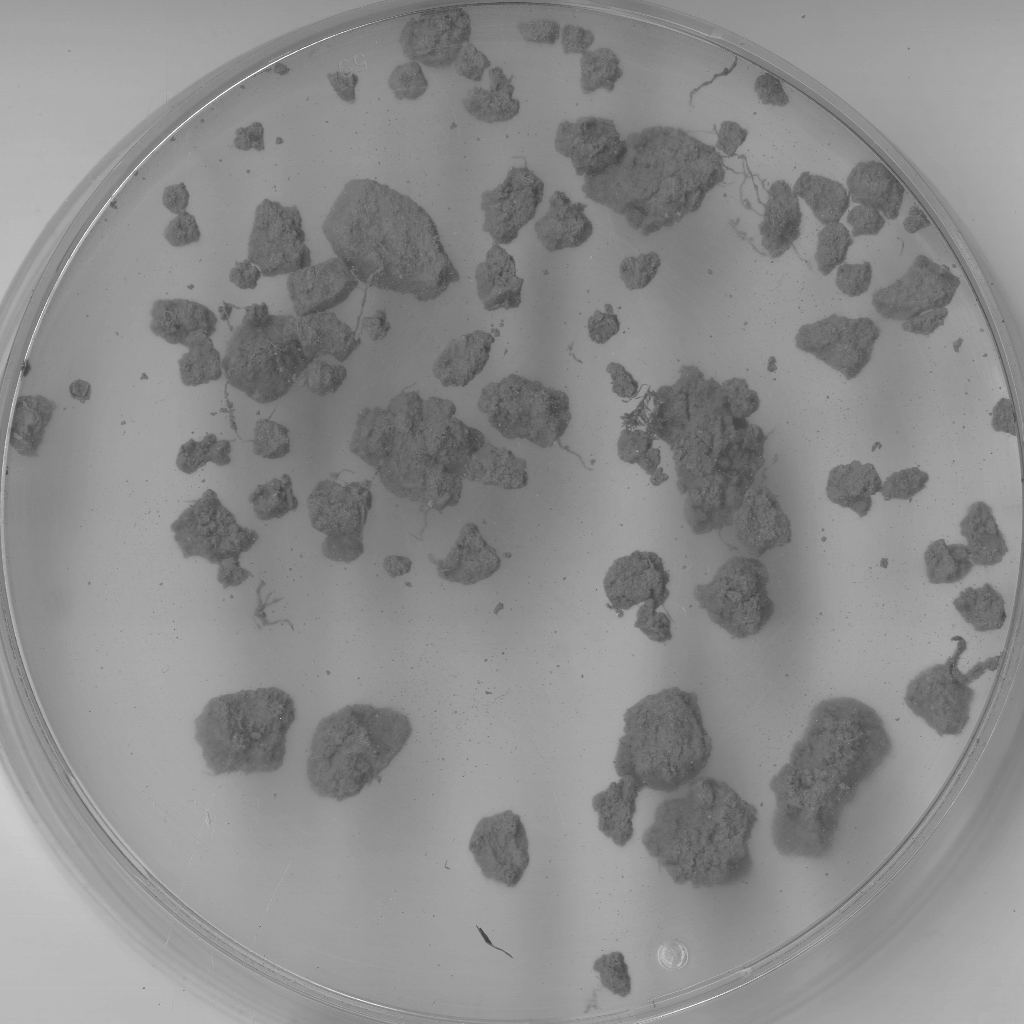

array([[157, 157, 157, ..., 157, 157, 157],
       [158, 157, 157, ..., 157, 157, 157],
       [158, 157, 157, ..., 157, 157, 157],
       ...,
       [184, 185, 184, ..., 179, 179, 179],
       [184, 185, 184, ..., 179, 179, 179],
       [184, 185, 185, ..., 179, 179, 179]], dtype=uint8)

In [ ]:
cv2_imshow(gh_images[1])
gh_images[1]

In [ ]:
gh_images[0].ndim

2

In [ ]:
all_images = gh_images + lp_images

feature_vectors = []

for curr_img in all_images:

  curr_contours,curr_perimeters,curr_areas = get_image_contours(curr_img)
  curr_aspects,curr_extents,curr_solidities,curr_diameters = get_shape_features(curr_contours)

  lbp_dist = get_lbp(curr_img,curr_contours)

  perimeter_dist = get_distribution(curr_perimeters,20)
  area_dist = get_distribution(curr_areas,20)
  aspect_dist = get_distribution(curr_aspects,20)
  extent_dist = get_distribution(curr_extents,20)
  solidity_dist = get_distribution(curr_solidities,20)

  vec = lbp_dist.tolist() + perimeter_dist.tolist() + area_dist.tolist() + aspect_dist.tolist() + extent_dist.tolist() + \
    solidity_dist.tolist()

  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
  for i in range(4):
    for angle in angles:
      contrast,dissimiliarity,homogeneity,energy,correlation = get_glcmprops(curr_img,curr_contours,i,angle)

      vec += contrast.flatten().tolist() + dissimiliarity.flatten().tolist() + \
      homogeneity.flatten().tolist() + energy.flatten().tolist() + correlation.flatten().tolist()

  feature_vectors.append(vec)


In [ ]:
X = feature_vectors
y = all_values

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
splits = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  splits.append((train_idx,test_idx))

# XGBRegressor

## Hyperparameter tuning

In [ ]:
max_depth = [1,2]
n_estimators = [100,200,300]
learning_rate = [0.01,0.02,0.04]

In [ ]:
rmse_d = {}
for md in max_depth:
  for e in n_estimators:
    for lr in learning_rate:
      all_rmses = []
      for i,(train_idx,test_idx) in enumerate(kf.split(X)):
        X_train = np.take(X, train_idx, axis=0)
        y_train = np.take(y, train_idx, axis=0)

        X_val = np.take(X, test_idx, axis=0)
        y_val = np.take(y, test_idx, axis=0)

        X_train,X_val = scale_fit_transform(X_train,X_val)
        y_train,y_val = scale_fit_transform(y_train,y_val)

        xgb_m = XGBRegressor(n_estimators=e, max_depth=md, learning_rate=lr)
        xgb_m.fit(X_train,y_train)
        preds = xgb_m.predict(X_val)
        rmse = mean_squared_error(y_val,preds,squared=False)
        all_rmses.append(rmse)
      rmse_d[(md,e,lr)] = np.average(all_rmses)
      print(md,e,lr,':',rmse_d[(md,e,lr)])



1 100 0.01 : 0.9872355355710407
1 100 0.02 : 0.9860797613519902
1 100 0.04 : 0.9916621319447023
1 200 0.01 : 0.9857954247056785
1 200 0.02 : 0.991464773451604
1 200 0.04 : 1.0045859573639855
1 300 0.01 : 0.9873555239621096
1 300 0.02 : 0.9987283530525592
1 300 0.04 : 1.0167787751127455
2 100 0.01 : 0.9902168663187261
2 100 0.02 : 0.9919661723439711
2 100 0.04 : 0.9997093704399933
2 200 0.01 : 0.9923676339642838
2 200 0.02 : 0.998962835844415
2 200 0.04 : 1.0117370114204454
2 300 0.01 : 0.9953180287166022
2 300 0.02 : 1.0091635299315218
2 300 0.04 : 1.0238355804558616


In [ ]:
dict(sorted(rmse_d.items(), key=lambda item: item[1]))

{(1, 200, 0.01): 0.9857954247056785,
 (1, 100, 0.02): 0.9860797613519902,
 (1, 100, 0.01): 0.9872355355710407,
 (1, 300, 0.01): 0.9873555239621096,
 (2, 100, 0.01): 0.9902168663187261,
 (1, 200, 0.02): 0.991464773451604,
 (1, 100, 0.04): 0.9916621319447023,
 (2, 100, 0.02): 0.9919661723439711,
 (2, 200, 0.01): 0.9923676339642838,
 (2, 300, 0.01): 0.9953180287166022,
 (1, 300, 0.02): 0.9987283530525592,
 (2, 200, 0.02): 0.998962835844415,
 (2, 100, 0.04): 0.9997093704399933,
 (1, 200, 0.04): 1.0045859573639855,
 (2, 300, 0.02): 1.0091635299315218,
 (2, 200, 0.04): 1.0117370114204454,
 (1, 300, 0.04): 1.0167787751127455,
 (2, 300, 0.04): 1.0238355804558616}

## Best model


------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


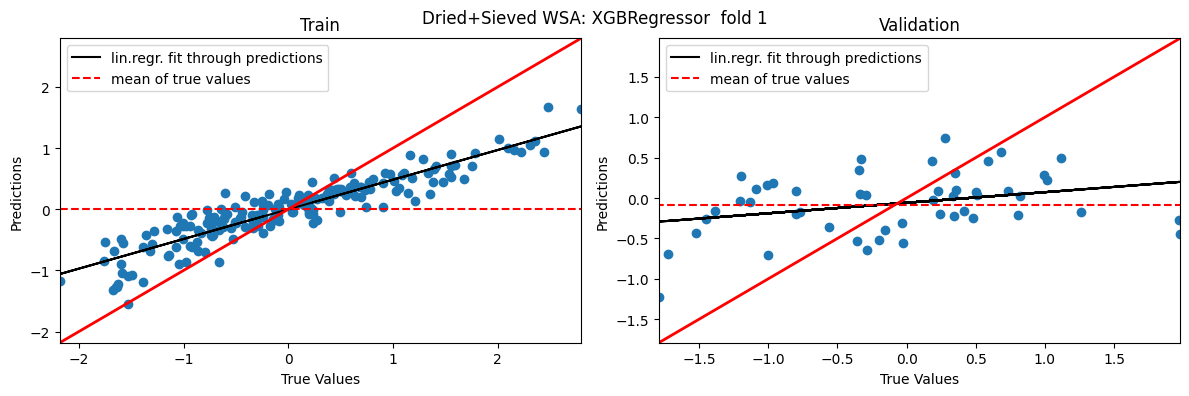

Train RMSE: 0.5572232844065989, MAE: 0.445622766014677
Validation RMSE: 0.8588560021211162, MAE: 0.6970688388510742
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


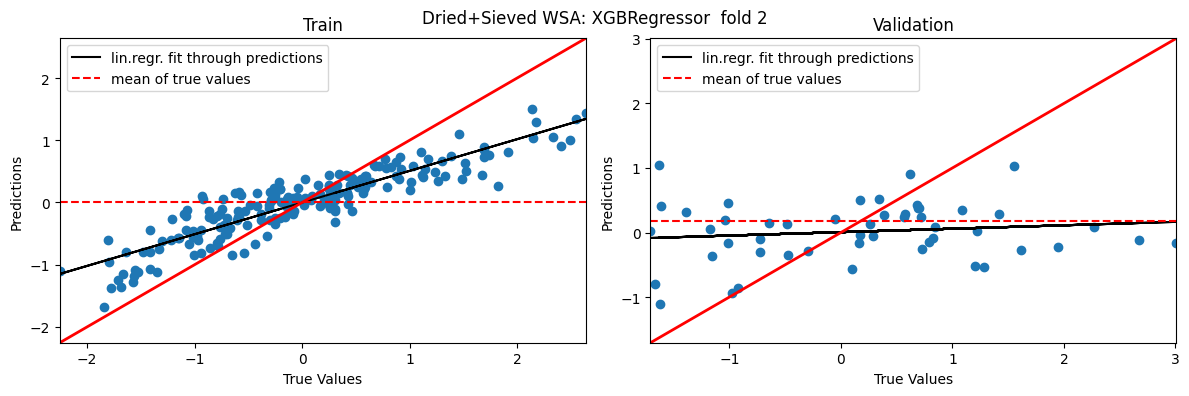

Train RMSE: 0.5461345673344408, MAE: 0.42853454637132943
Validation RMSE: 1.1996531674752051, MAE: 0.9105947747109439
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


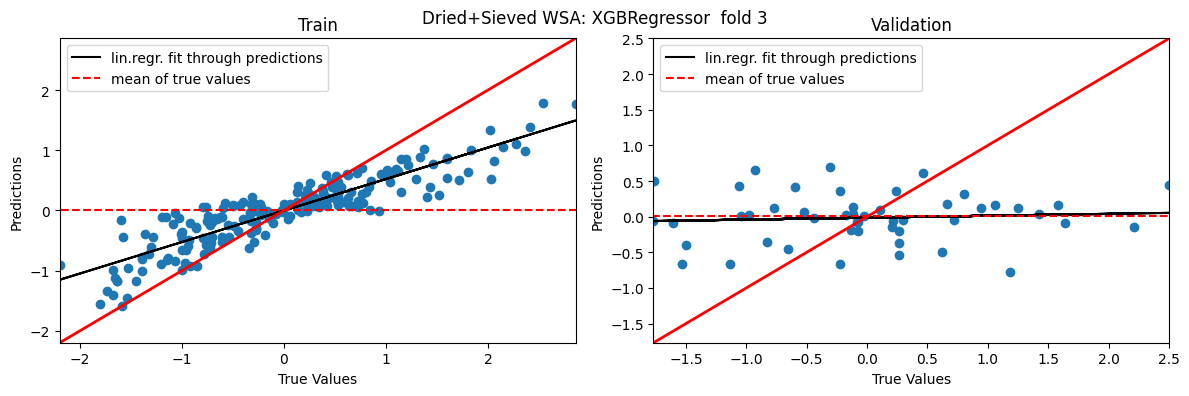

Train RMSE: 0.5411181126774461, MAE: 0.41761109202924657
Validation RMSE: 1.0186144021488839, MAE: 0.8007466673943844
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


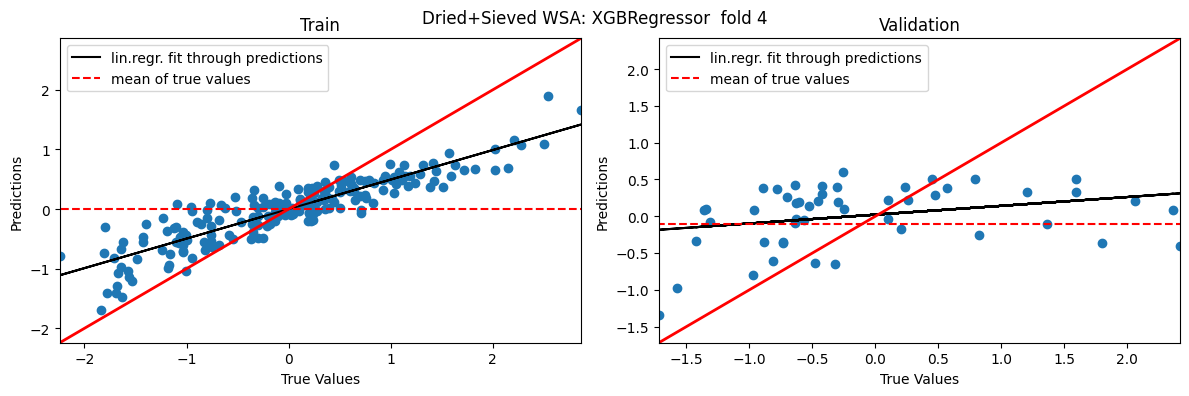

Train RMSE: 0.5620982996861874, MAE: 0.4379307331373702
Validation RMSE: 0.9970237136472461, MAE: 0.7927653845136271
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


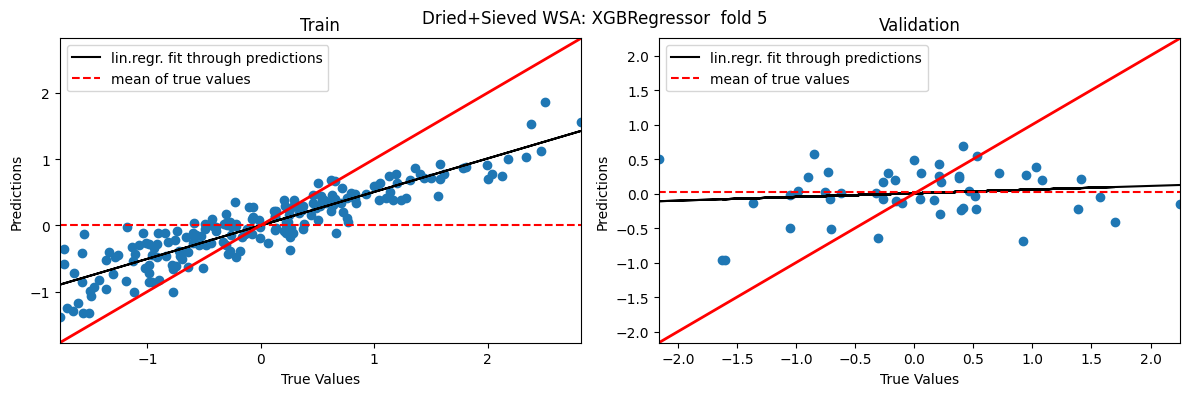

Train RMSE: 0.5464024772884543, MAE: 0.435768656206545
Validation RMSE: 0.9319994324127683, MAE: 0.705518730831246


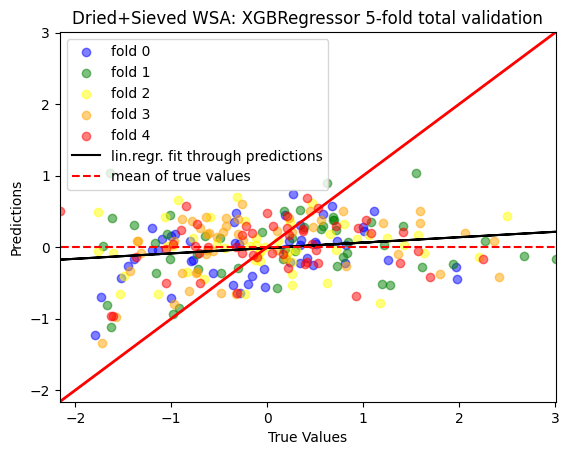

Total validation RMSE: 1.0079693371317673
Total validation MAE: 0.7815210082280345


In [ ]:
run_5fold('XGBRegressor','Dried+Sieved','WSA', model_dict,splits,X,y,False,None)

#RandomForestRegressor

## Hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rmse_dt = {}
for md in range(1,9,2):
  for e in range(10,200,30):
    all_rmses = []
    for i,(train_idx,test_idx) in enumerate(kf.split(X)):
      X_train = np.take(X, train_idx, axis=0)
      y_train = np.take(y, train_idx, axis=0)

      X_val = np.take(X, test_idx, axis=0)
      y_val = np.take(y, test_idx, axis=0)

      X_train,X_val = scale_fit_transform(X_train,X_val)
      y_train,y_val = scale_fit_transform(y_train,y_val)

      rf_m = RandomForestRegressor(max_depth=md,n_estimators=e)
      rf_m.fit(X_train,y_train.ravel())
      preds = rf_m.predict(X_val)
      rmse = mean_squared_error(y_val.ravel(),preds,squared=False)
      all_rmses.append(rmse)
    rmse_dt[(md,e)] = np.average(all_rmses)
    print(md,e,':',rmse_dt[(md,e)])

1 10 : 0.9871497903495294
1 40 : 0.9787628650701403
1 70 : 0.9782608543322031
1 100 : 0.9765848708942046
1 130 : 0.9808398167948956
1 160 : 0.9760897560756157
1 190 : 0.9803106363220351
3 10 : 0.9955537686002638
3 40 : 0.9800777714843475
3 70 : 0.9689937890033411
3 100 : 0.9761230664793553
3 130 : 0.9734191545031112
3 160 : 0.9853491728535679
3 190 : 0.9778126434470573
5 10 : 1.014420202123574
5 40 : 0.9871550410749309
5 70 : 0.9864572543638289
5 100 : 0.9932876850719987
5 130 : 0.9830118020715751
5 160 : 0.9820664050586873
5 190 : 0.975921096857703
7 10 : 1.0327465984185795
7 40 : 0.9792966180633403
7 70 : 0.9947302631706366
7 100 : 0.9865498632977902
7 130 : 0.9837436022094085
7 160 : 0.9819047884894803
7 190 : 0.9713180060765876


In [ ]:
dict(sorted(rmse_dt.items(), key=lambda item: item[1]))

{(3, 70): 0.9689937890033411,
 (7, 190): 0.9713180060765876,
 (3, 130): 0.9734191545031112,
 (5, 190): 0.975921096857703,
 (1, 160): 0.9760897560756157,
 (3, 100): 0.9761230664793553,
 (1, 100): 0.9765848708942046,
 (3, 190): 0.9778126434470573,
 (1, 70): 0.9782608543322031,
 (1, 40): 0.9787628650701403,
 (7, 40): 0.9792966180633403,
 (3, 40): 0.9800777714843475,
 (1, 190): 0.9803106363220351,
 (1, 130): 0.9808398167948956,
 (7, 160): 0.9819047884894803,
 (5, 160): 0.9820664050586873,
 (5, 130): 0.9830118020715751,
 (7, 130): 0.9837436022094085,
 (3, 160): 0.9853491728535679,
 (5, 70): 0.9864572543638289,
 (7, 100): 0.9865498632977902,
 (1, 10): 0.9871497903495294,
 (5, 40): 0.9871550410749309,
 (5, 100): 0.9932876850719987,
 (7, 70): 0.9947302631706366,
 (3, 10): 0.9955537686002638,
 (5, 10): 1.014420202123574,
 (7, 10): 1.0327465984185795}

## Best model

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


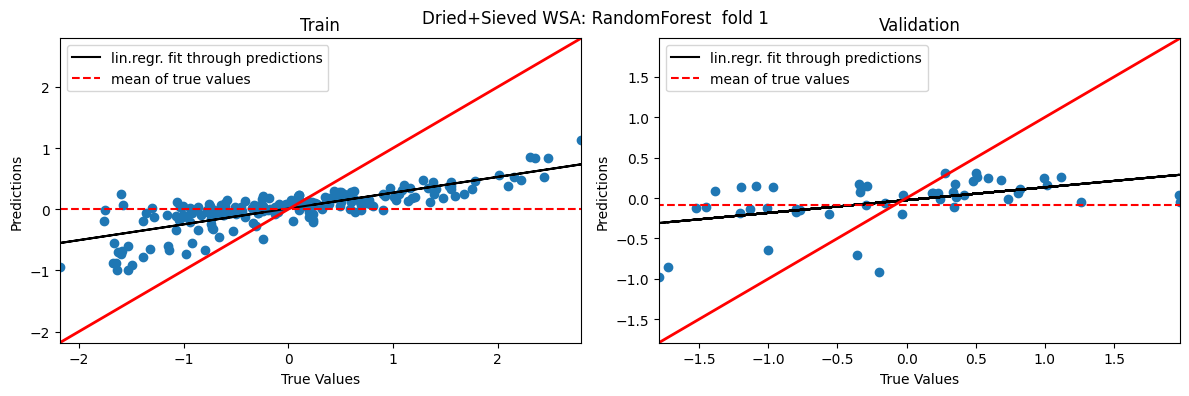

Train RMSE: 0.7679851344449297, MAE: 0.6272418950063632
Validation RMSE: 0.8004587337427749, MAE: 0.6449509463212066
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


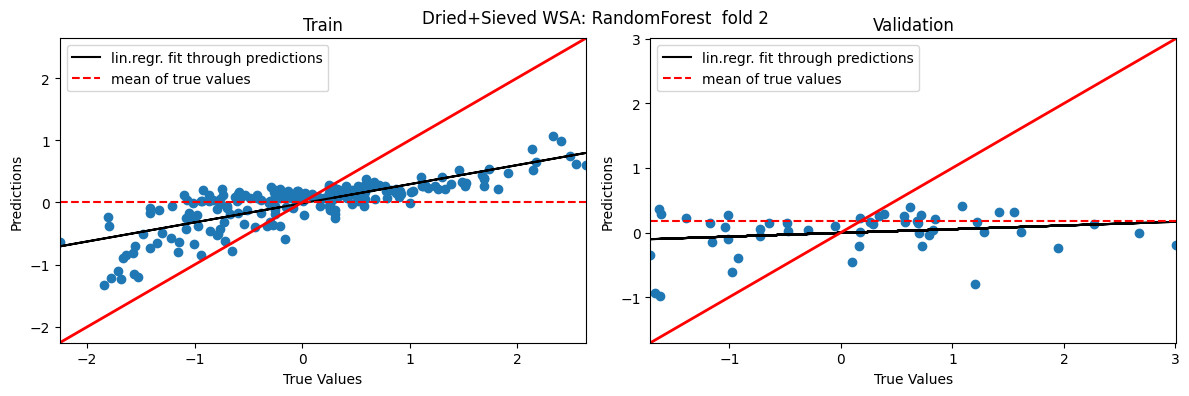

Train RMSE: 0.7326640422324608, MAE: 0.5923855203172371
Validation RMSE: 1.1525878760147745, MAE: 0.9151174851884253
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


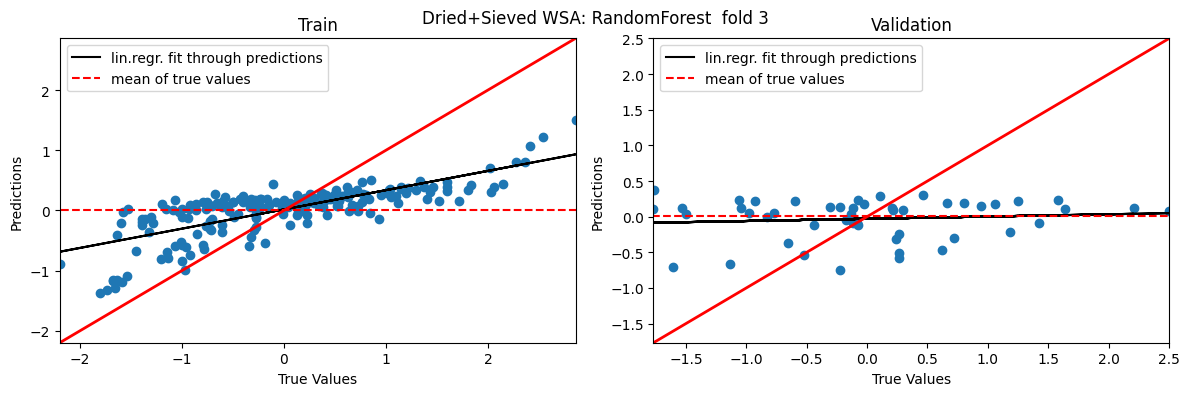

Train RMSE: 0.7331762630521235, MAE: 0.5939195334382266
Validation RMSE: 0.9954056385191691, MAE: 0.782562748581148
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


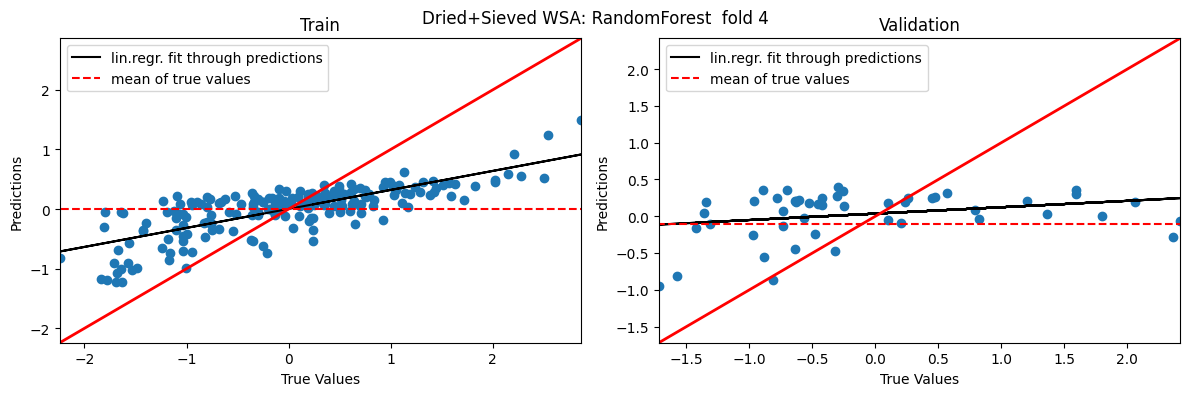

Train RMSE: 0.7322163113972255, MAE: 0.5931446489580098
Validation RMSE: 0.9979894155146799, MAE: 0.8105494682805158
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


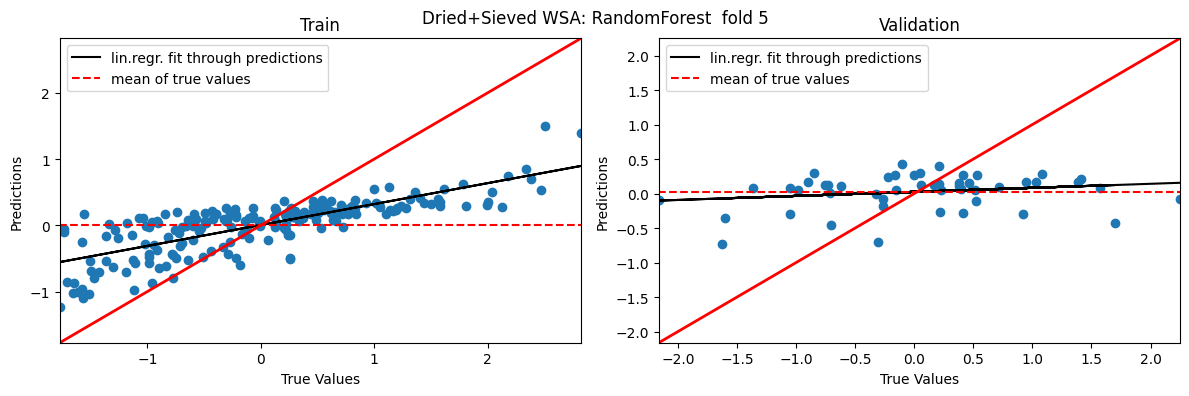

Train RMSE: 0.730579616555994, MAE: 0.5911612260380336
Validation RMSE: 0.8887463009347786, MAE: 0.7013546812036427


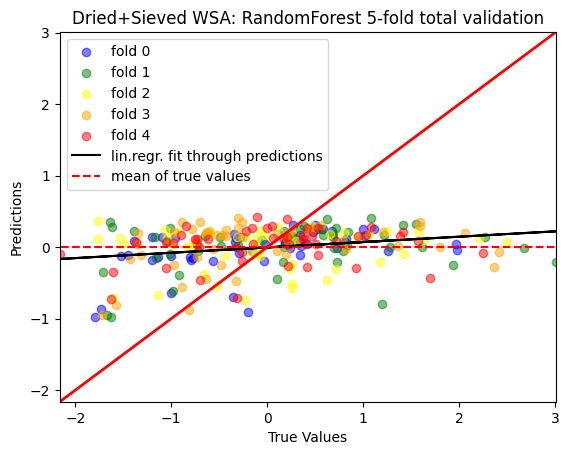

Total validation RMSE: 0.9744036417172484
Total validation MAE: 0.7709809699622737


In [ ]:
run_5fold('RandomForest','Dried+Sieved','WSA', model_dict,splits,X,y,False,None)